# Youtube PHD

In [13]:
library(pacman)
p_load(quantmod,vars)

In [14]:
library(quantmod)
#CA as share of GDP, but Reserves in dollars
#Need to get MX GDP in dollars
#Get NGDP in pesos and exchange rate
setDefaults(getSymbols,src='FRED')
getSymbols("MEXB6BLTT02STSAQ",src='FRED')
###I now added code to truncate each series to match the video!
MEXB6BLTT02STSAQ=MEXB6BLTT02STSAQ["/2019-10-01"]
CA<-ts(MEXB6BLTT02STSAQ,end=c(2019,4),freq=4)
mean(CA)

[1] "MEXB6BLTT02STSAQ"

[1] -1.526069

In [3]:
getSymbols("MEXGDPNQDSMEI",src='FRED')
MEXGDPNQDSMEI=MEXGDPNQDSMEI["/2019-10-01"]
NGDP<-ts(MEXGDPNQDSMEI,end=c(2019,4),freq=4)

getSymbols("CCUSMA02MXQ618N",src='FRED')
CCUSMA02MXQ618N=CCUSMA02MXQ618N["/2020-01-01"]
MXNUSD<-ts(CCUSMA02MXQ618N,end=c(2020,1),freq=4)
NGDPUSD<-NGDP/MXNUSD

[1] "MEXGDPNQDSMEI"

[1] "CCUSMA02MXQ618N"

In [4]:
#KFA = diff(Reserves) - CA
getSymbols("MEXB6FARA01CXCUQ",src='FRED')
MEXB6FARA01CXCUQ=MEXB6FARA01CXCUQ["/2019-10-01"]
RES<-ts(MEXB6FARA01CXCUQ,end=c(2019,4),freq=4)
KFA<-(100*diff(RES)/NGDPUSD-CA)
mean(100*diff(RES)/NGDPUSD)
mean(KFA)

[1] "MEXB6FARA01CXCUQ"

[1] -0.005479293

[1] 1.54415

In [5]:
getSymbols("MANMM101MXQ189S",src='FRED')
MANMM101MXQ189S=MANMM101MXQ189S["/2018-10-01"]
MXM1<-ts(MANMM101MXQ189S,end=c(2018,4),freq=4)

getSymbols("BOGZ1FL072052006Q",src='FRED')  
BOGZ1FL072052006Q=BOGZ1FL072052006Q["/2019-10-01"]
USR<-ts(BOGZ1FL072052006Q,end=c(2019,4),freq=4)

getSymbols("GDPC1",src='FRED') 
GDPC1=GDPC1["/2020-01-01"]
USY<-ts(GDPC1,end=c(2020,1),freq=4)

getSymbols("NAEXKP01MXQ189S",src='FRED')   
NAEXKP01MXQ189S=NAEXKP01MXQ189S["/2019-10-01"]
MXY<-ts(NAEXKP01MXQ189S,end=c(2019,4),freq=4)

[1] "MANMM101MXQ189S"

[1] "BOGZ1FL072052006Q"

[1] "GDPC1"

[1] "NAEXKP01MXQ189S"

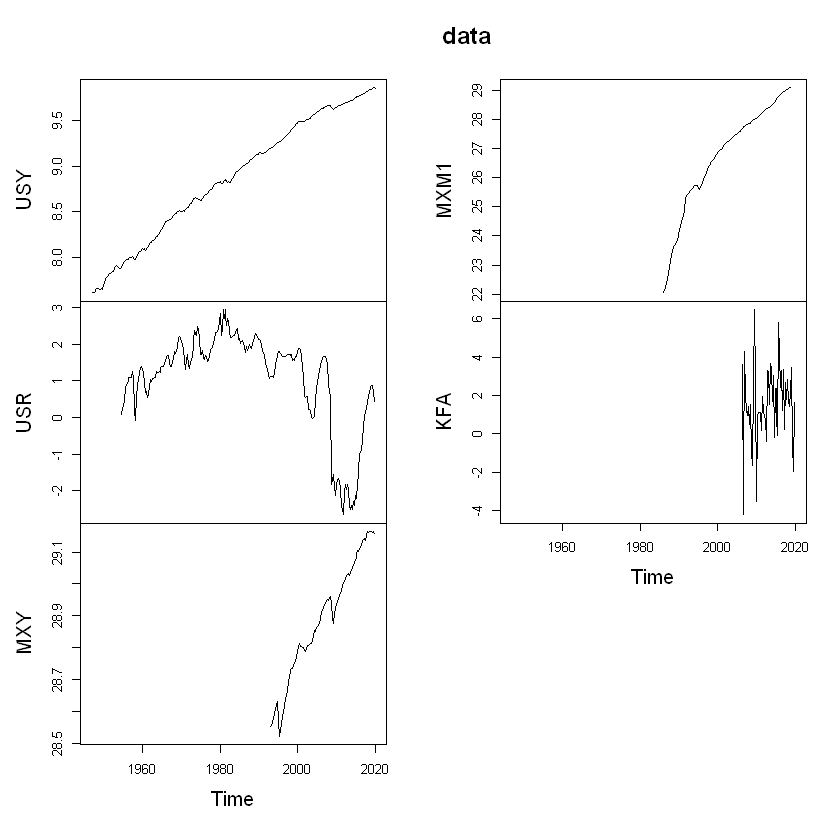

[1] 51  5

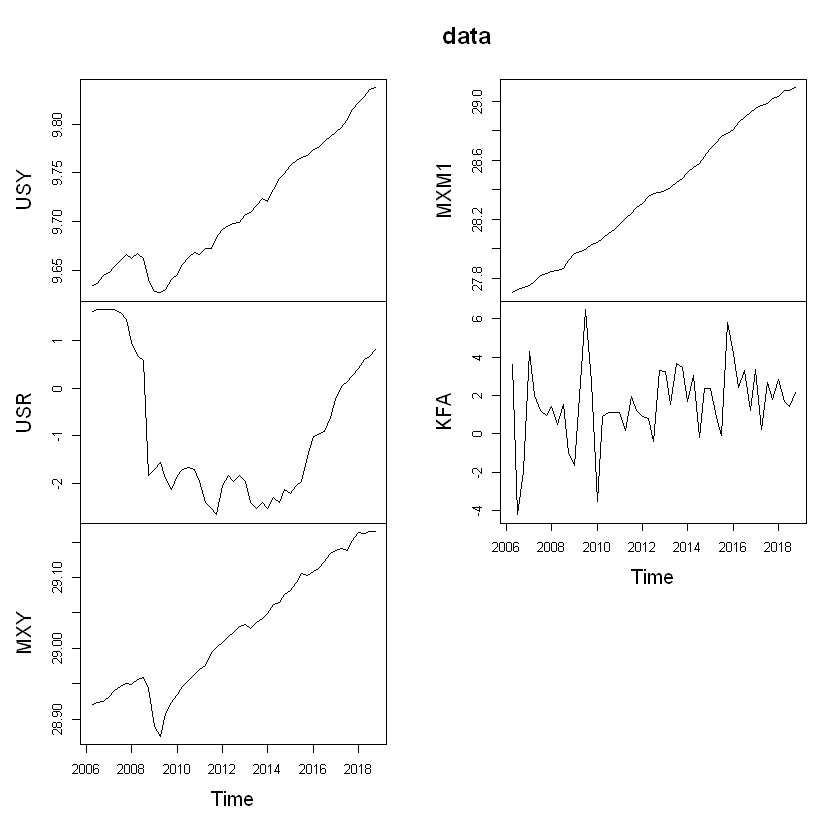

In [6]:
#Take logs of 3 variables
#Combine; notice different lengths
data<-cbind(log(USY),log(USR),log(MXY),log(MXM1),KFA)
names<-c("USY","USR","MXY","MXM1","KFA")
colnames(data)<-names
plot(data)
data<-na.omit(data)
plot(data)
dim(data)

In [7]:
#Here: 51 Quarters, 2006-2018

#Phillips-Perron stationarity test
pptab<-NULL
for(i in 1:ncol(data)){
pp<-PP.test(data[,i])
pptab<-rbind(pptab,pp$p.value)
}
pptab

0.7745719
0.9595579
0.4892190
0.4010632
0.0100000


In [8]:
#redo with differences
data<-cbind(diff(log(USY)),diff(USR),diff(log(MXY)),diff(log(MXM1)),KFA)
data<-na.omit(data)
colnames(data)<-names

pptab<-NULL
for(i in 1:ncol(data)){
  pp<-PP.test(data[,i])
  pptab<-rbind(pptab,pp$p.value)
}
pptab

0.01
0.01
0.01
0.01
0.01


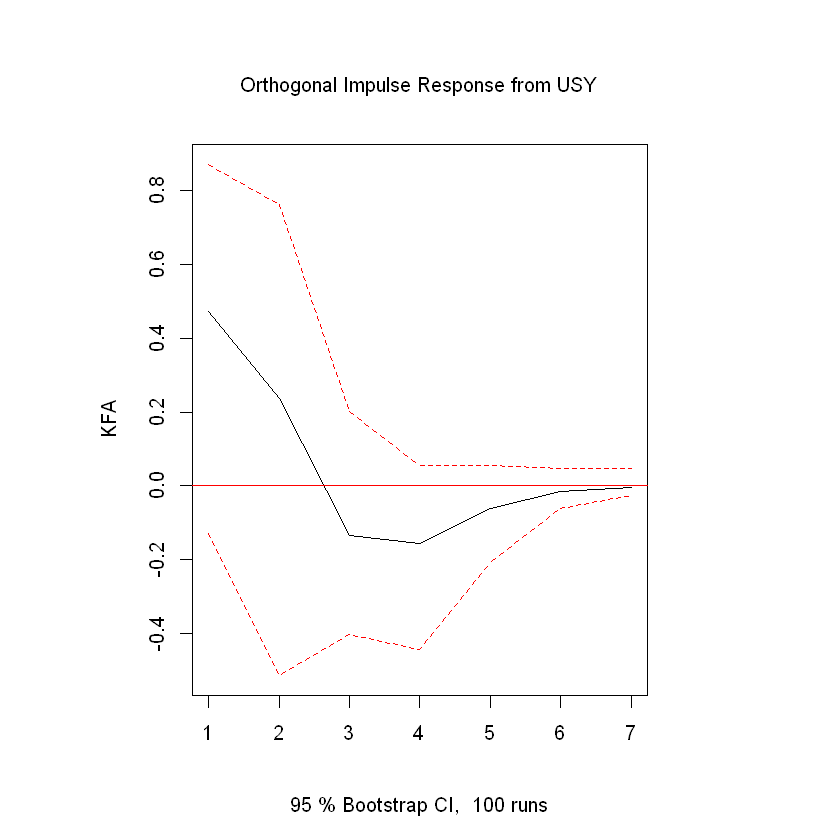

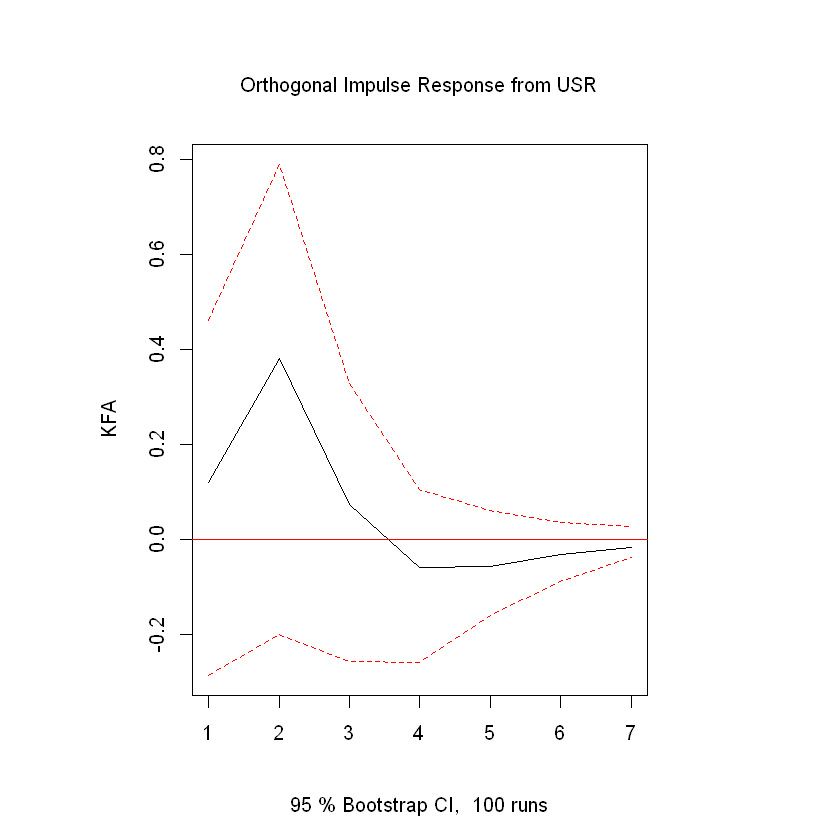

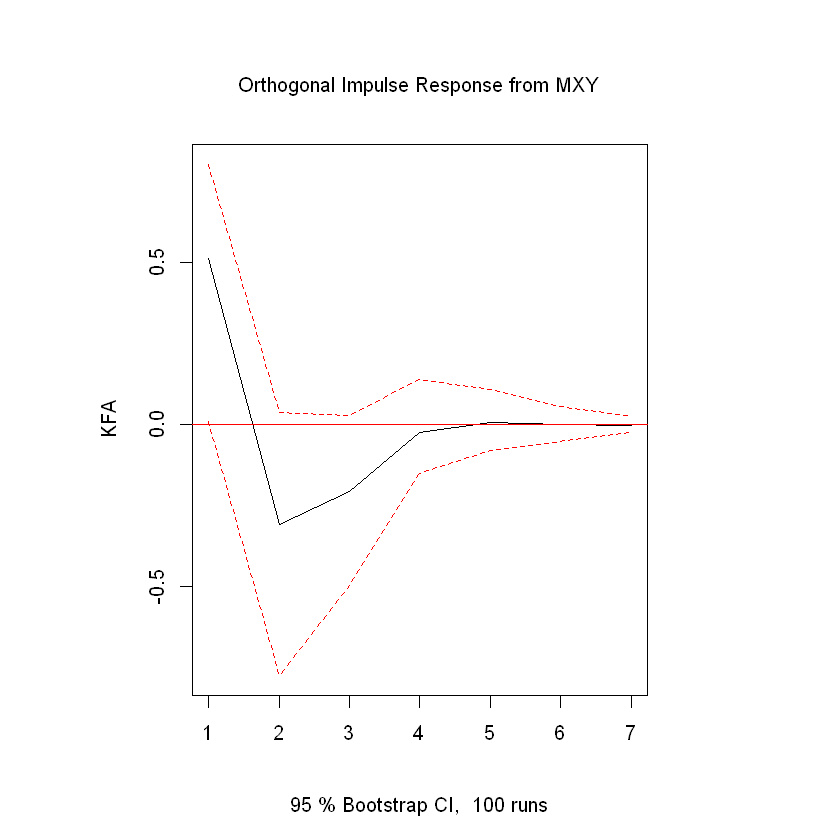

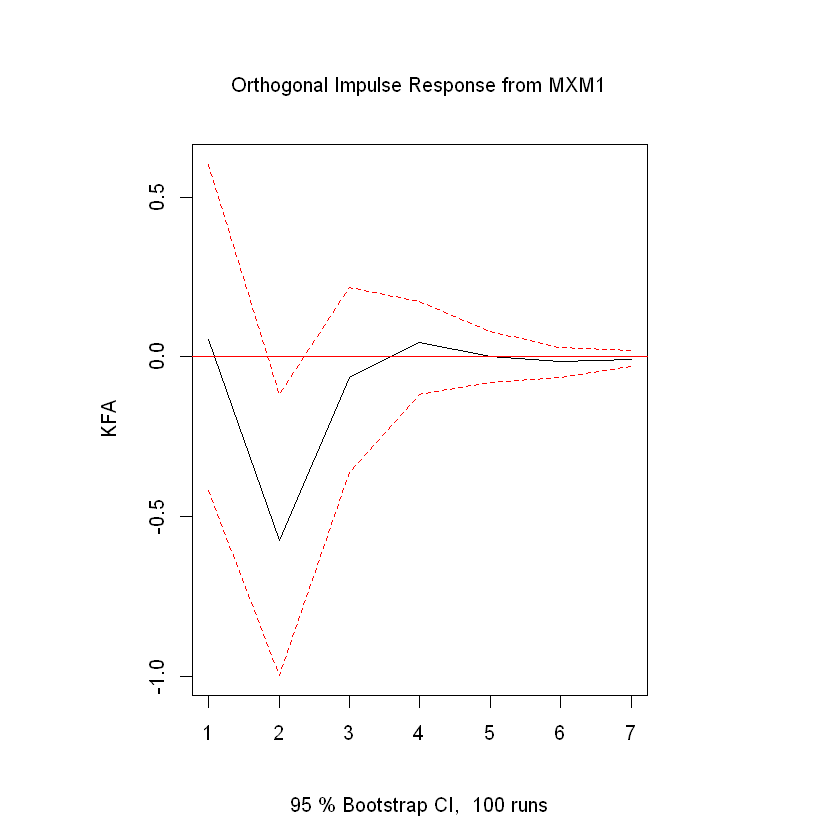

In [9]:
#plot IRFs: Make VAR (LOWER triangular: Order with most exogenous on left and most endogenous on right)
#Loop to only make response of CA
#Still default settings
var<-data
library(vars)
var1<-VAR(var,type = c("const"),lag.max = 4,ic="SC")
for(i in 1:4){
  irf1<-irf(var1,impulse = colnames(var1$datamat[i]),response = colnames(var1$datamat[5]),n.ahead = 6,ortho = TRUE,ci=0.95,boot=TRUE,runs=100,cumulative = FALSE)
plot(irf1)
}

    USY  USR  MXY MXM1   KFA
1  6.23 0.41 7.40 0.08 85.88
4  7.36 3.87 9.20 7.75 71.82
8  7.44 3.96 9.18 7.74 71.68
12 7.44 3.96 9.18 7.74 71.68


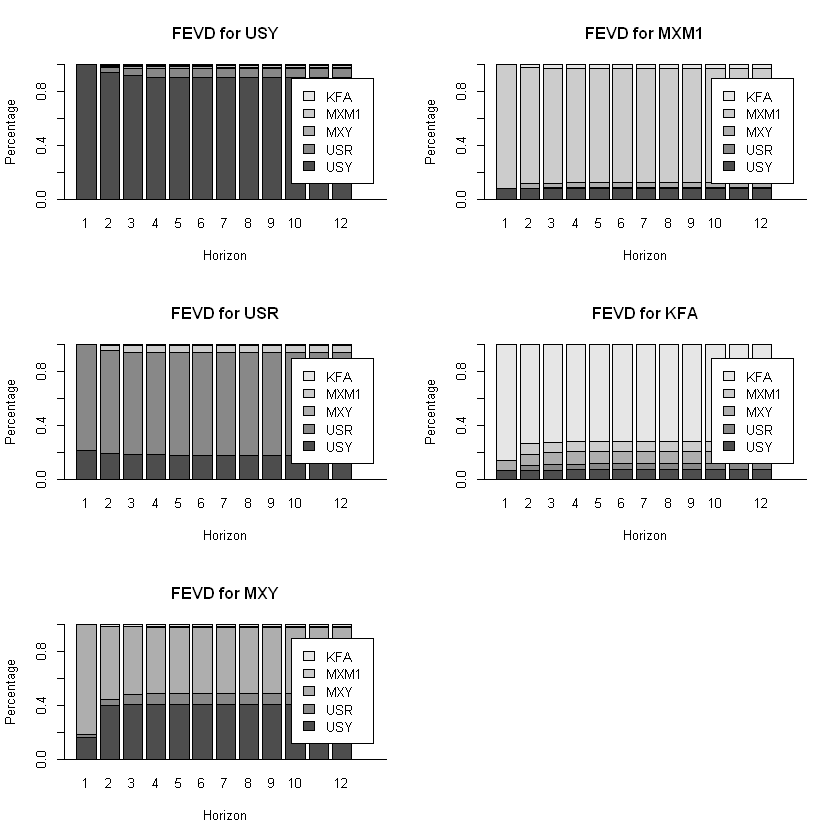

In [11]:
#Get FEVDs at 1,4,8,12-quarter horizons
fevd1<-fevd(var1,n.ahead = 12)
fevd2<-fevd1$KFA
fevdtab<-round(100*fevd2[c(1,4,8,12),],2)
rownames(fevdtab)<-c(1,4,8,12)
print(fevdtab)
plot(fevd1)

     Statistic p-val.
USY      0.047  0.829
USR      0.891  0.348
MXY      1.869  0.175
MXM1     4.809  0.031


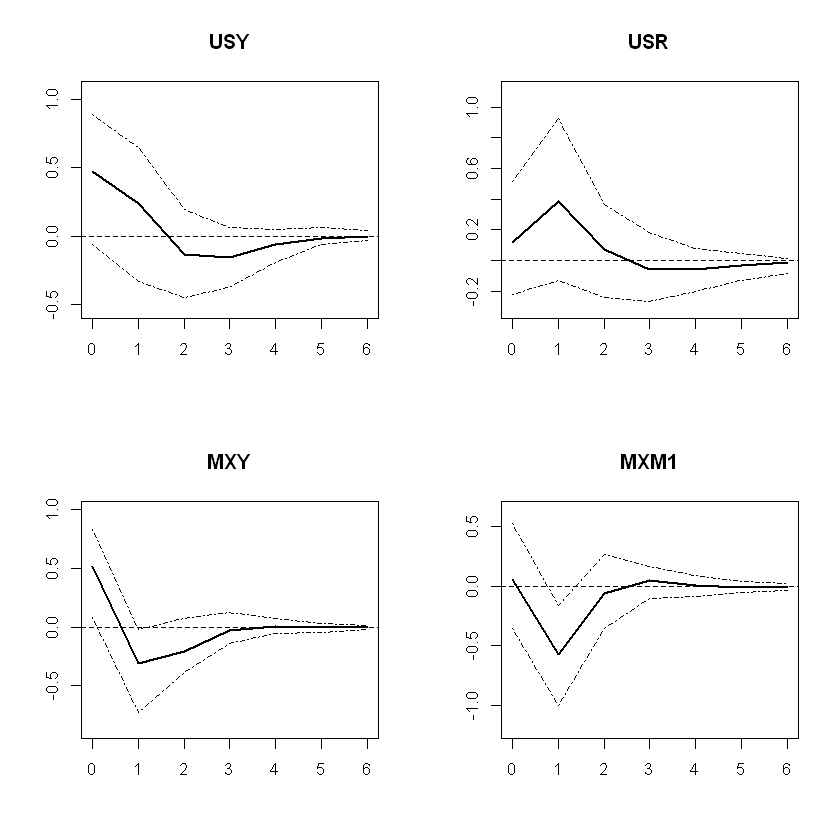

In [10]:
#Granger Causality tests: I make pairwise vars, then a nice table
gctab<-NULL
var<-data
library(vars)
var1<-VAR(var,type = c("const"),lag.max = 4,ic="SC")
for(i in 1:4){
   var2<-VAR(var[,c(i,5)],type = c("const"),lag.max = 4,ic="SC")
  gc<-causality(var2,cause = colnames(var1$datamat[i]))
  gc1<-cbind(as.numeric(gc$Granger$statistic),gc$Granger$p.value)
  gctab<-rbind(gctab,gc1)
}
colnames(gctab)<-c("Statistic","p-val.")
rownames(gctab)<-colnames(var1$datamat[c(1:4)])
gctab<-round(gctab,3)
print(gctab)

#Here I plot my own IRFs!
irfx<-c(0:6)
par(mfrow=c(2,2))
for(i in 1:4){
  irf1<-irf(var1,impulse = colnames(var1$datamat[i]),response = colnames(var1$datamat[5]),n.ahead = 6,ortho = TRUE,ci=0.95,boot=TRUE,runs=100,cumulative = FALSE)
  volirf1<-unlist(irf1[1]$irf[1])
  volirf1l<-unlist(irf1[2]$Lower[1])
  volirf1u<-unlist(irf1[3]$Upper[1])
  
  #par(new=FALSE)
  plot(irfx,volirf1,type="l",lwd=2,ylab="",xlab="",cex.lab=2, ylim=1.2*c(min(volirf1l),max(volirf1u)),main=colnames(var1$datamat[i]))
  par(new=TRUE)
  plot(irfx,volirf1l,type="l",lwd=1,ylab="",xlab="",lty=4,ylim=1.2*c(min(volirf1l),max(volirf1u)))
  par(new=TRUE)
  plot(irfx,volirf1u,type="l",lwd=1,ylab="",xlab="",lty=4,ylim=1.2*c(min(volirf1l),max(volirf1u)))
  abline(h=0,lty=2,lwd=1.5)
  }

# Web

$$ 
\begin{pmatrix} y_{1,t}\\ y_{2,t} \end{pmatrix} =
\begin{bmatrix} -0.3 & -0.4 \\ 0.6 & 0.5 \end{bmatrix} \begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \end{pmatrix} +
\begin{bmatrix} -0.1 & 0.1 \\ -0.2 & 0.05 \end{bmatrix} \begin{pmatrix} y_{1,t-2} \\ y_{2,t-2} \end{pmatrix} +
\begin{pmatrix} \epsilon_{1t} \\ \epsilon_{2t} \end{pmatrix}
$$

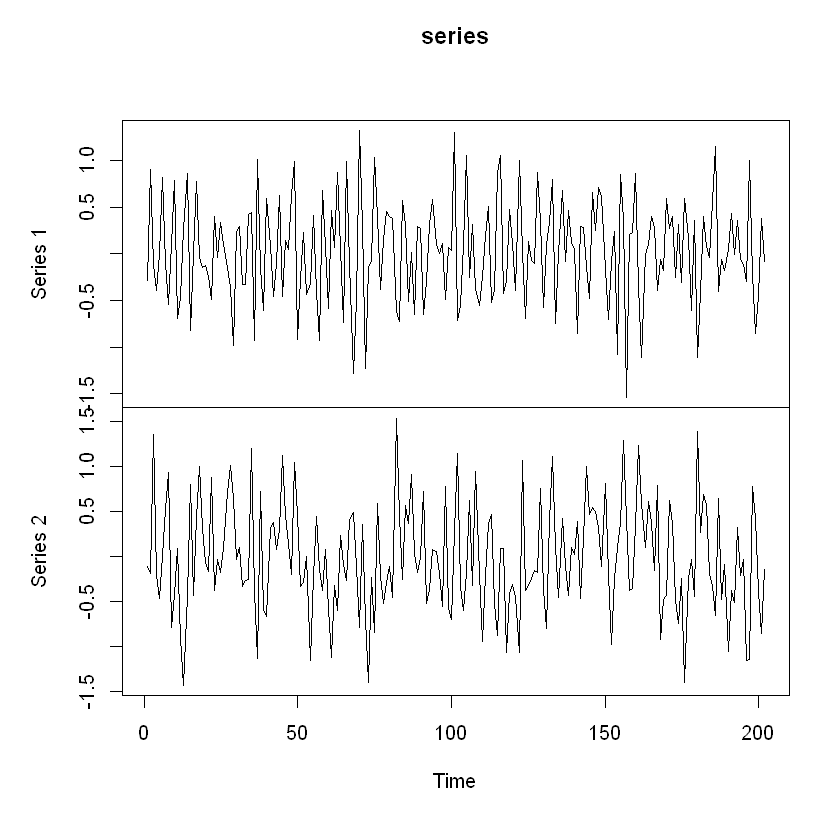

In [15]:
set.seed(123) # Reset random number generator for reasons of reproducability

# Generate sample
t <- 200 # Number of time series observations
k <- 2 # Number of endogenous variables
p <- 2 # Number of lags

# Generate coefficient matrices
A.1 <- matrix(c(-.3, .6, -.4, .5), k) # Coefficient matrix of lag 1
A.2 <- matrix(c(-.1, -.2, .1, .05), k) # Coefficient matrix of lag 2
A <- cbind(A.1, A.2) # Companion form of the coefficient matrices

# Generate series
series <- matrix(0, k, t + 2*p) # Raw series with zeros
for (i in (p + 1):(t + 2*p)){ # Generate series with e ~ N(0,0.5)
  series[, i] <- A.1%*%series[, i-1] + A.2%*%series[, i-2] + rnorm(k, 0, .5)
}

series <- ts(t(series[, -(1:p)])) # Convert to time series format
names <- c("V1", "V2") # Rename variables

plot.ts(series) # Plot the series

In [16]:
var.1 <- VAR(series, 2, type = "none") # Estimate the model

In [17]:
var.aic <- VAR(series, type = "none", lag.max = 5, ic = "AIC")

In [18]:
summary(var.aic)


VAR Estimation Results:
Endogenous variables: Series.1, Series.2 
Deterministic variables: none 
Sample size: 200 
Log Likelihood: -266.065 
Roots of the characteristic polynomial:
0.6611 0.6611 0.4473 0.03778
Call:
VAR(y = series, type = "none", lag.max = 5, ic = "AIC")


Estimation results for equation Series.1: 
Series.1 = Series.1.l1 + Series.2.l1 + Series.1.l2 + Series.2.l2 

            Estimate Std. Error t value Pr(>|t|)    
Series.1.l1 -0.19750    0.06894  -2.865  0.00463 ** 
Series.2.l1 -0.32015    0.06601  -4.850 2.51e-06 ***
Series.1.l2 -0.23210    0.07586  -3.060  0.00252 ** 
Series.2.l2  0.04687    0.06478   0.724  0.47018    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.4638 on 196 degrees of freedom
Multiple R-Squared: 0.2791,	Adjusted R-squared: 0.2644 
F-statistic: 18.97 on 4 and 196 DF,  p-value: 3.351e-13 


Estimation results for equation Series.2: 
Series.2 = Series.1.l1 + Series.2.l1 + Series.1.l2 + Series.2.l2 

In [19]:
A

-0.3,-0.4,-0.1,0.10
0.6,0.5,-0.2,0.05


In [20]:
# Extract coefficients, standard errors etc. from the object
# produced by the VAR function
est_coefs <- coef(var.aic)

# Extract only the coefficients for both dependend variables
# and combine them to a single matrix
est_coefs <- rbind(est_coefs[[1]][, 1], est_coefs[[2]][, 1]) 

# Print the rounded estimates in the console
round(est_coefs, 2)

Series.1.l1,Series.2.l1,Series.1.l2,Series.2.l2
-0.20,-0.32,-0.23,0.05
0.67,0.34,-0.18,0.07


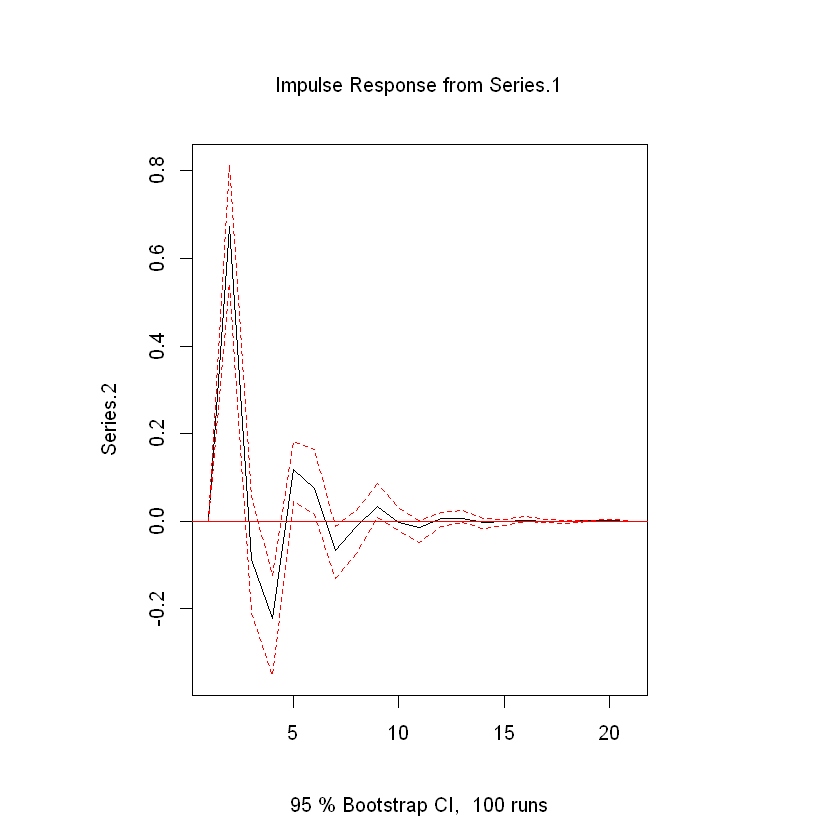

In [21]:
# Calculate the IRF
ir.1 <- irf(var.1, impulse = "Series.1", response = "Series.2", n.ahead = 20, ortho = FALSE)

# Plot the IRF
plot(ir.1)

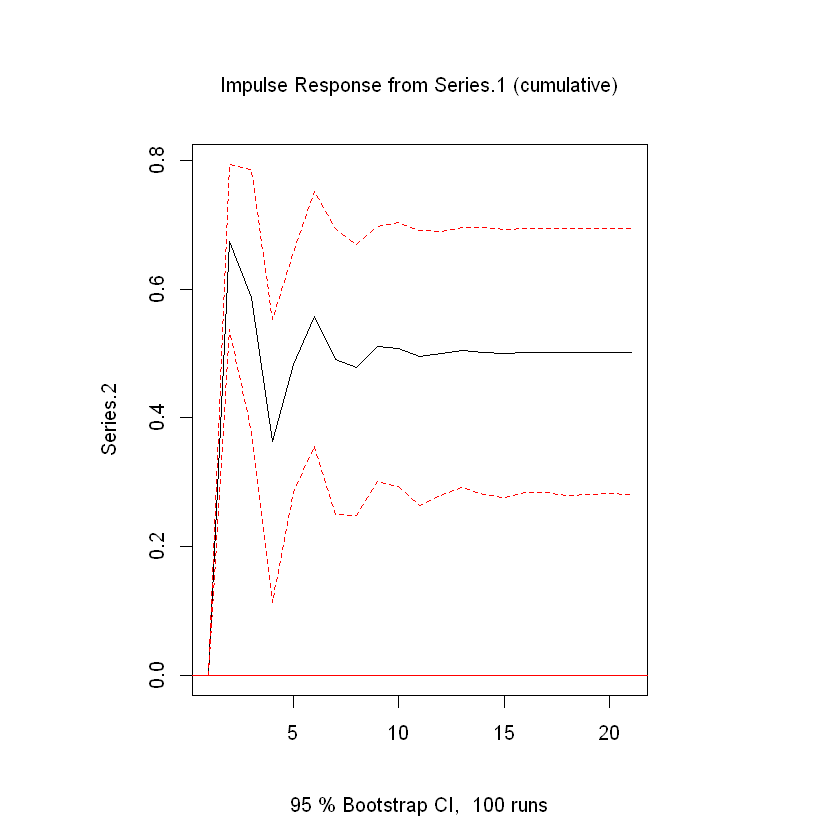

In [22]:
# Calculate impulse response
ir.2 <- irf(var.1,impulse="Series.1",response="Series.2",n.ahead = 20,ortho = FALSE,
cumulative = TRUE)

# Plot
plot(ir.2)

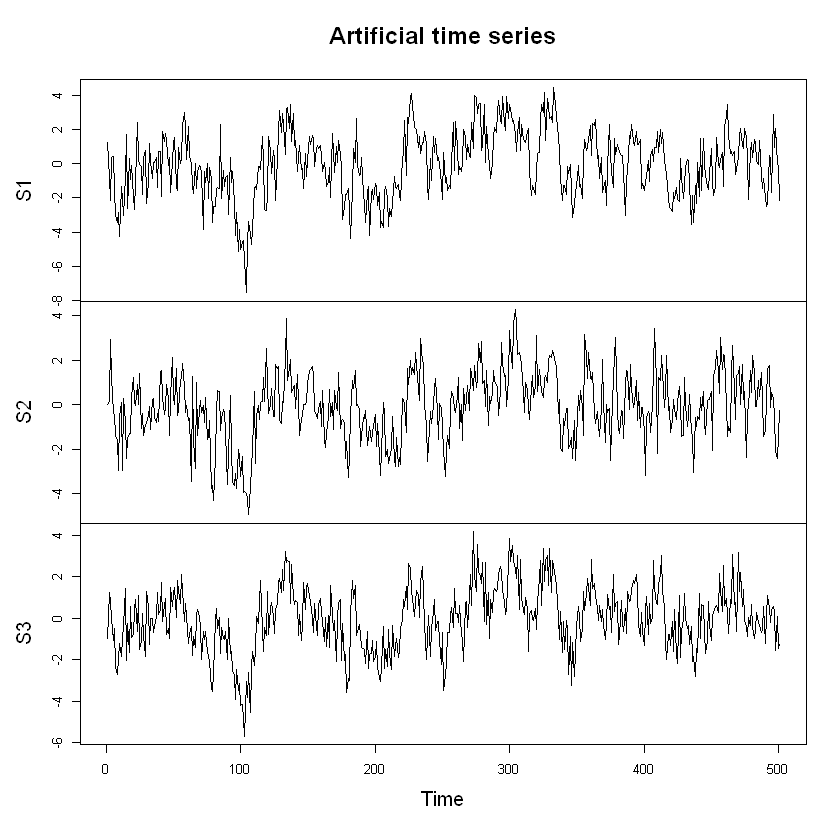

In [23]:
# Reset random number generator for reproducibility
set.seed(24579)

tt <- 500 # Number of time series observations

# Coefficient matrix
A_1 <- matrix(c(0.3, 0, 0.24,
                0.12, 0.3, 0.24,
                0.69, 0.48, 0.3), 3)

# Structural coefficients
B <- diag(1, 3)
B[lower.tri(B)] <- c(-0.14, -0.06, 0.39)

# Generate series
series <- matrix(rnorm(3, 0, 1), 3, tt + 1) # Raw series with zeros
for (i in 2:(tt + 1)){
  series[, i] <- A_1 %*% series[, i - 1] +  B %*% rnorm(3, 0, 1)
}

series <- ts(t(series)) # Convert to time series object
dimnames(series)[[2]] <- c("S1", "S2", "S3") # Rename variables

# Plot the series
plot.ts(series, main = "Artificial time series")


In [24]:
# Estimate reduced form VAR
var_est <- VAR(series, p = 1, type = "none")

var_est


VAR Estimation Results:

Estimated coefficients for equation S1: 
Call:
S1 = S1.l1 + S2.l1 + S3.l1 

    S1.l1     S2.l1     S3.l1 
0.3288079 0.1124078 0.6809865 


Estimated coefficients for equation S2: 
Call:
S2 = S1.l1 + S2.l1 + S3.l1 

       S1.l1        S2.l1        S3.l1 
-0.001530688  0.289578440  0.512701274 


Estimated coefficients for equation S3: 
Call:
S3 = S1.l1 + S2.l1 + S3.l1 

    S1.l1     S2.l1     S3.l1 
0.2401861 0.2519319 0.3186145 



In [25]:
# Estimate structural coefficients
a <- diag(1, 3)
a[lower.tri(a)] <- NA

svar_est_a <- SVAR(var_est, Amat = a, max.iter = 1000)

svar_est_a


SVAR Estimation Results:


Estimated A matrix:
        S1      S2 S3
S1 1.00000  0.0000  0
S2 0.18177  1.0000  0
S3 0.05078 -0.3132  1

In [26]:
solve(svar_est_a$A)


,S1,S2,S3
S1,1.0000000,0.0000000,0
S2,-0.1817747,1.0000000,0
S3,-0.1077103,0.3131988,1


In [27]:
svar_est_a$Ase

,S1,S2,S3
S1,0.00000000,0.00000000,0
S2,0.04472136,0.00000000,0
S3,0.04545420,0.04472136,0


In [28]:
# Create structural matrix with restrictions
b <- diag(1, 3)
b[lower.tri(b)] <- NA

# Estimate
svar_est_b <- SVAR(var_est, Bmat = b)

# Show result
svar_est_b


SVAR Estimation Results:


Estimated B matrix:
        S1     S2 S3
S1  1.0000 0.0000  0
S2 -0.1818 1.0000  0
S3 -0.1077 0.3132  1

In [29]:
svar_est_b$Bse

,S1,S2,S3
S1,0.00000000,0.00000000,0
S2,0.04472136,0.00000000,0
S3,0.04686349,0.04472136,0
